This script will fetch locations of all venues in the Austin area that match a certain criteria (coffe, bar, bubble tea etc.).

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

print('folium imported')

folium imported


Since foursquare queries cannot return more than 50 venues at a time we have to run multiple scans to cover all the area.
To do this I will divide the area into square 1kmx1km cells.
1 KM is equal to 1/111 degrees. 

In [2]:
km=1/111
lat_A=30.2672
lng_A=-97.7431
lat=lat_A-km*7
lng=lng_A-km*10

Define functions that will later be used for calculating weight function.

In [3]:
def age_func(a):
    sss=12
    mu=20    yy=1/np.sqrt(2*3.1415*sss**2)*np.exp(-(a-mu)**2/(2*sss**2))/0.033245680287071734
    return yy

def dist_func(a):
    y=1/(1+np.exp((a-600)/100))
    return y

def inc_func(a):
    y=1-1/(1+np.exp((a-50000)/10000))
    return y

#optimization p

In [4]:
CLIENT_ID = 'SVC2EATH3GGQLSZVIQFAW1PH0O2RDX5K0H30ZJ3LOBKRR4SK' # your Foursquare ID
CLIENT_SECRET = '1A0VXT2XCTZ10JBCRLFKYNJDDHLTUHNIM43TTNY5WJ1DISL0' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SVC2EATH3GGQLSZVIQFAW1PH0O2RDX5K0H30ZJ3LOBKRR4SK
CLIENT_SECRET:1A0VXT2XCTZ10JBCRLFKYNJDDHLTUHNIM43TTNY5WJ1DISL0


Initialise the database with 4 columns: id of venue, name and geo coordinates.

In [5]:
col=['id','name','location.lat','location.lng']
db  = pd.DataFrame(columns = col)
db.head()
db.shape

(0, 4)

Run the search query with raduis of sqrt(2)*1KM for every node of the square grid. Save the information to db dataframe

In [6]:
radius = 1000*np.sqrt(2)
from pandas.io.json import json_normalize

n=30

gridx=np.linspace(lat,lat+15*km,n)
gridy=np.linspace(lng,lng+15*km,n)

for ind_i, i in enumerate(gridx):
    print(ind_i,'/',n)
    for j in gridy:
        search_query = 'coffee'
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, i, j, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['venues']
        dataframe = json_normalize(venues)
        if venues!=[]:
            dataframe.head()
            df=dataframe[['id','name','location.lat','location.lng']].copy()
            frames = [db, df]
            db = pd.concat(frames)

0 / 30
1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30


In [71]:
db.head()

id                            name  location.lat  \
0  4aa51b71f964a520674720e3                       Starbucks     30.207837   
0  584978d8e03e5771646253d8      Summer Moon Coffee Trailer     30.205375   
0  579b791e498e9bd835c09ce6             Machine Head Coffee     30.210956   
1  4f32165119836c91c7b47a90  Ag Horn Coffee Service Company     30.215841   
0  58c549ff13c2236f0d0ffd8d                Ruta Maya Coffee     30.203389   

   location.lng  
0    -97.815372  
0    -97.806272  
0    -97.771058  
1    -97.763750  
0    -97.704302

Get rid of the duplicates because some venues were scanned multiple times.

In [8]:
db.drop_duplicates(inplace=True)
db.to_csv('coffee7.csv')
db.shape

(180, 4)

Load information about zipcodes, density, median income and age.

In [36]:
zip_demo=pd.read_csv('zip_all.csv')
zd=zip_demo.set_index('zip')
zd.head()

lat        lng    den  income   age
zip                                             
78705  30.293474 -97.738268  11009   14740  21.2
78751  30.310819 -97.722821   5822   29799  28.1
78752  30.331288 -97.704660   5436   30207  27.1
78741  30.229845 -97.715136   5346   25369  23.9
78723  30.305341 -97.683344   5176   34242  28.3

In [26]:
X=pd.DataFrame(columns=['lat','lng','zip','density','income','age'])
X.loc[0]=[0,0,0,0,0,0]
X.head()


lat lng zip density income age
0   0   0   0       0      0   0

Assign zipcode, population density and demographics information to each cell, based on distance to the closest Central zipcode. 

In [ ]:
n=30
gridx=np.linspace(lat,lat+15*km,n)
gridy=np.linspace(lng,lng+15*km,n)


ind=0
for i in gridx:
    for j in gridy: 
        z=0
        m=10
        for k in zd.index:
            lat1=zd.loc[k]['lat']
            lng1=zd.loc[k]['lng']
            m1=(i-lat1)**2+(j-lng1)**2
            print(m1,lat1,lng1)
            if m1<m:
                m=m1
                z=k
                

        X.loc[ind]=[i,j,z,zd.loc[z]['den'],zd.loc[z]['income'],zd.loc[z]['age']]

        ind=ind+1




    

In [ ]:
X.to_csv('coffee_all.csv')

In [ ]:
db1=db.set_index('id')
db1.head()

Find the closest competing venue for each node. Calculate distance to the venue.

In [45]:

ind=0
s=db1.shape[0]
min_D=[]
for i in gridx:
    for j in gridy: 
        m=100
        for k in db1.index:
            lat1=db1.loc[k]['location.lat']
            lng1=db1.loc[k]['location.lng']
            m1=np.sqrt((i-lat1)**2+(j-lng1)**2)
            if m1<m:
                m=m1
        min_D.append(m)
        ind=ind+1

In [46]:
X1=pd.DataFrame(columns=['minD','f'])
Y = pd.concat([X, X1], axis=1, sort=False)



In [48]:
for i in range(len(min_D)):
    Y.at[i,'minD']=min_D[i]*111*1000 
#populate frame with average distance converted to meters

In [49]:
Y.to_csv('final_coffee.csv')
Y.head()

lat      lng    zip density income   age     minD    f
0  30.2041 -97.8332  78749    2795  68244  32.2  1960.59  NaN
1  30.2041 -97.8285  78749    2795  68244  32.2  1517.25  NaN
2  30.2041 -97.8239  78745    4063  43458  31.3  1028.88  NaN
3  30.2041 -97.8192  78745    4063  43458  31.3  591.809  NaN
4  30.2041 -97.8146  78745    4063  43458  31.3  420.658  NaN

In [ ]:
print(age_func(32),dist_func(200))
Y.describe()

Calculate the weight function for each node.

In [51]:
function
for i in range(len(min_D)):
    den=Y.at[i,'density']
    inc=Y.at[i,'income']
    age=Y.at[i,'age']
    s=Y.at[i,'minD']
    Y.at[i,'f']=den*age_func(age)*(1+inc_func(inc)-dist_func(s)) 

Show it on the map!

In [70]:
Austin=folium.Map(location=[lat_A, lng_A], zoom_start=12)



ind=0
for i in gridx:
    for j in gridy:    
        folium.CircleMarker(
        [i, j],
        radius=6,
        color='blue',
        weight=0,
        fill=True,
        parse_html=False,
        fill_color='blue',
        fill_opacity=Y.at[ind,'f']/10000,  #
        line_opacity=0
        ).add_to(Austin)
        ind=ind+1
       
  
for lat, lng in zip(db['location.lat'],db['location.lng']):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        fill=False,
        parse_html=False).add_to(Austin)
  
    
       
Austin

In [ ]:
Y.head()

Supplementary part that shows functions used in calculation of weight function.

Text(0,0.5,'Coffee shop attendance')

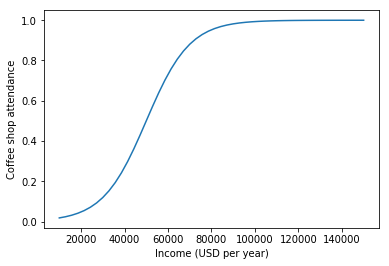

In [64]:
xx=np.linspace(10000,150000)
yy=inc_func(xx)
plt.plot(xx,yy)
plt.xlabel('Income (USD per year)')
plt.ylabel('Coffee shop attendance')


Text(0,0.5,'Coffee shop attendance')

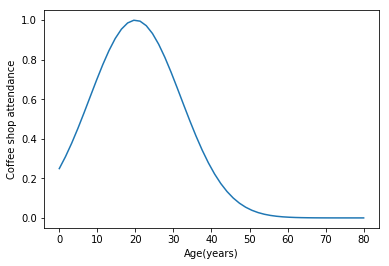

In [65]:
xx=np.linspace(0,80)
yy=age_func(xx)
plt.plot(xx,yy)
plt.xlabel('Age(years)')
plt.ylabel('Coffee shop attendance')

Text(0,0.5,'Competition')

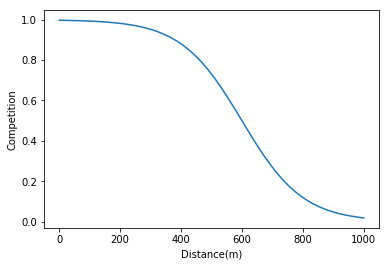

In [67]:
xx=np.linspace(0,1000)
yy=dist_func(xx)
plt.plot(xx,yy)
plt.xlabel('Distance(m)')
plt.ylabel('Competition')

Let's just check how median income depends on median age.

Text(0,0.5,'Income')

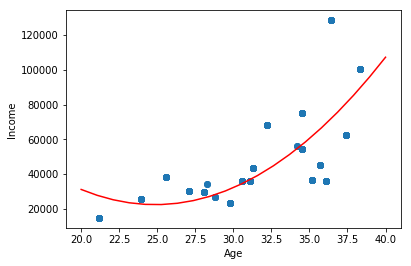

In [117]:
plt.scatter(Y['age'],Y['income'])
x=np.asarray(Y['age'])
y=np.asarray(Y['income'])

x=x.reshape((900,1)) 
y=y.reshape((900,1))

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

clf = linear_model.LinearRegression()
train_y_ = clf.fit(x_poly, y)

yyy=clf.fit(x_poly,y)

xv=(np.linspace(20,40,20)).reshape((20,1))
xv_poly=poly.fit_transform(xv)
yv=clf.predict(xv_poly)

plt.plot(xv,yv,c='red')
plt.xlabel('Age')
plt.ylabel('Income')

Plotting a heatmap for the optimization function.

Text(33,0.5,'Distance(m)')

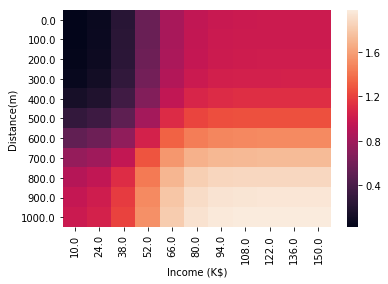

In [170]:
M=11
x=np.linspace(0,1000,M)
y=np.linspace(10000,150000,M)/1000



box = pd.DataFrame(index=x, columns=y)

for i in range(M):
    for j in range(M):
        box.iloc[i,j]=(1+inc_func(1000*y[j])-dist_func(x[i]))

box=box.astype('float')
        
import seaborn as sns

ax=sns.heatmap(box)
plt.xlabel('Income (K$)')
plt.ylabel('Distance(m)')

10000.000000  17368.421053  24736.842105  32105.263158   \
0.000000        0.0204588     0.0393296     0.0765064       0.14561   
52.631579       0.0221644     0.0410352      0.078212      0.147315   
105.263158      0.0250382     0.0439089     0.0810858      0.150189   
157.894737       0.029865     0.0487357     0.0859126      0.155016   
210.526316      0.0379291     0.0567999     0.0939767       0.16308   
263.157895      0.0512833      0.070154      0.107331      0.176434   
315.789474      0.0730771     0.0919478      0.129125      0.198228   
368.421053        0.10781      0.126681      0.163858      0.232961   
421.052632       0.161123      0.179994      0.217171      0.286275   
473.684211       0.238417      0.257288      0.294465      0.363568   
526.315789       0.341681      0.360552      0.397729      0.466832   
578.947368       0.465548      0.484419      0.521596      0.590699   
631.578947       0.596284      0.615155      0.652332      0.721435   
684.210526       0.716895      0.735765      0.772942      0.842046   
736.842105       0.815111      0.833982      0.871159      0.940262   
789.473684       0.887281      0.906152      0.943328       1.01243   
842.105263       0.936405      0.955276      0.992452       1.06156   
894.736842       0.968125      0.986996       1.02417       1.09328   
947.368421       0.987916       1.00679       1.04396       1.11307   
1000.000000             1       1.01887       1.05605       1.12515   

            39473.684211  46842.105263  54210.526316  61578.947368   \
0.000000         0.261193      0.424175      0.606208      0.763423   
52.631579        0.262898       0.42588      0.607913      0.765128   
105.263158       0.265772      0.428754      0.610787      0.768002   
157.894737       0.270599      0.433581      0.615614      0.772829   
210.526316       0.278663      0.441645      0.623678      0.780893   
263.157895       0.292017      0.454999      0.637032      0.794247   
315.789474       0.313811      0.476793      0.658826      0.816041   
368.421053       0.348544      0.511526      0.693559      0.850774   
421.052632       0.401857      0.564839      0.746872      0.904087   
473.684211       0.479151      0.642133      0.824166      0.981381   
526.315789       0.582415      0.745397       0.92743       1.08465   
578.947368       0.706282      0.869264        1.0513       1.20851   
631.578947       0.837018             1       1.18203       1.33925   
684.210526       0.957629       1.12061       1.30264       1.45986   
736.842105        1.05585       1.21883       1.40086       1.55807   
789.473684        1.12801         1.291       1.47303       1.63024   
842.105263        1.17714       1.34012       1.52215       1.67937   
894.736842        1.20886       1.37184       1.55387       1.71109   
947.368421        1.22865       1.39163       1.57366       1.73088   
1000.000000       1.24073       1.40372       1.58575       1.74296   

            68947.368421  76315.789474  83684.210526  91052.631579   \
0.000000         0.871767      0.935339      0.969176      0.986254   
52.631579        0.873473      0.937045      0.970881       0.98796   
105.263158       0.876347      0.939918      0.973755      0.990834   
157.894737       0.881173      0.944745      0.978582       0.99566   
210.526316       0.889238      0.952809      0.986646       1.00372   
263.157895       0.902592      0.966164             1       1.01708   
315.789474       0.924386      0.987957       1.02179       1.03887   
368.421053       0.959118       1.02269       1.05653       1.07361   
421.052632        1.01243         1.076       1.10984       1.12692   
473.684211        1.08973        1.1533       1.18713       1.20421   
526.315789        1.19299       1.25656        1.2904       1.30748   
578.947368        1.31686       1.38043       1.41426       1.43134   
631.578947        1.44759       1.51116         1.545       1.56208   
684.210526         1.5682       1.

In [128]:
np.linspace(0,1000,20)

array([   0.        ,   52.63157895,  105.26315789,  157.89473684,
        210.52631579,  263.15789474,  315.78947368,  368.42105263,
        421.05263158,  473.68421053,  526.31578947,  578.94736842,
        631.57894737,  684.21052632,  736.84210526,  789.47368421,
        842.10526316,  894.73684211,  947.36842105, 1000.        ])